In [1]:
import numpy as np

In [2]:
from TFANN import ANNR
import matplotlib.pyplot as mpl
from sklearn.preprocessing import scale

In [3]:
import datetime as dt

In [4]:
from datetime import datetime

In [5]:
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''

    def __init__(self, N, K):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N

    def transform(self, A, Y = None):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #Matrix of sample indices like: {{1, 2..., M}, {2, 3, ..., M + 1}}
        I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        B = A[I].reshape(-1, M * A.shape[1], *A.shape[2:])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix


In [6]:
import numpy as np
import os
import pandas as pd
import urllib.request
     

In [7]:
def GetAPIUrl(cur, sts = 1420070400):
    '''
    Makes a URL for querying historical prices of a cyrpto from Poloniex
    cur:    3 letter abbreviation for cryptocurrency (BTC, LTC, etc)
    '''
    return 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_{:s}&start={:d}&end=9999999999&period=7200'.format(cur, sts)
 
def GetCurDF(cur, fp):
    '''
    cur:    3 letter abbreviation for cryptocurrency (BTC, LTC, etc)
    fp:     File path (to save price data to CSV)
    '''
    openUrl = urllib.request.urlopen(GetAPIUrl(cur))
    r = openUrl.read()
    openUrl.close()
    df = pd.read_json(r.decode())
    df['date'] = df['date'].astype(np.int64) // 1000000000   ## datetime.fromtimestamp(1424138400) to convert back
    return df
 

In [8]:
#%%Path to store cached currency data
datPath = 'CurDat/'
if not os.path.exists(datPath):
    os.mkdir(datPath)
#Different cryptocurrency types
cl = ['XRP']
#Columns of price data to use
CN = ['close', 'high', 'low', 'open', 'volume']
#Store data frames for each of above types
D = []
for ci in cl:
    dfp = os.path.join(datPath, ci + '.csv')
    try:
        df = pd.read_csv(dfp, sep = ',')
    except FileNotFoundError:
        df = GetCurDF(ci, dfp)
    D.append(df)
#%%Only keep range of data that is common to all currency types
cr = min(Di.shape[0] for Di in D)
for i in range(len(cl)):
    D[i] = D[i][(D[i].shape[0] - cr):]

In [118]:
 #%%Features are channels
C = np.hstack([Di[CN] for Di in D])[:, None, :]
HP = 32                 #Holdout period   ## what's not going to be trained
A = C[0:-HP]                # A is now everything except for the last 32 rows (32*2 hours)
SV = A.mean(axis = 0)   #Scale vector   # takes the mean of the whole list and scales it
C /= SV                 #Basic scaling of data   # takes the mean of the whole list and scales it    ##!!! Here, something can be done, the scaling should be periodically
#%%Make samples of temporal sequences of pricing data (channel)
NPS, NFS = 256, 16         #Number of past and future samples
ps = PastSampler(NPS, NFS)
B, Y = ps.transform(A)

In [10]:
from TFANN import ANNR
 
NC = B.shape[2]
#2 1-D conv layers with relu followed by 1-d conv output layer
ns = [('C1d', [8, NC, NC * 2], 4), ('AF', 'relu'), 
      ('C1d', [8, NC * 2, NC * 2], 2), ('AF', 'relu'), 
      ('C1d', [8, NC * 2, NC], 2)]
#Create the neural network in TensorFlow
cnnr = ANNR(B[0].shape, ns, batchSize = 32, learnRate = 1e-5, 
            maxIter = 64, reg = 1e-5, tol = 1e-2, verbose = True)
cnnr.fit(B, Y)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Iter     1	      6.05661058 (Batch Size:    32)
Iter     2	      4.74080086 (Batch Size:    32)
Iter     3	      3.83253316 (Batch Size:    32)
Iter     4	      3.38120525 (Batch Size:    32)
Iter     5	      3.29615409 (Batch Size:    32)
Iter     6	      2.86179755 (Batch Size:    32)
Iter     7	      2.89369225 (Batch Size:    32)
Iter     8	      3.49662742 (Batch Size:    32)
Iter     9	      3.14843369 (Batch Size:    32)
Iter    10	      3.12758129 (Batch Size:    32)
Iter    11	      3.11013635 (Batch Size:    32)
Iter    12	      3.05216740 (Batch Size:    32)
Iter    13	      3.01369865 (Batch Size:    32)
Iter    14	      3.23331543 (Batch Size:    32)
Iter    15	      3.4

In [11]:
PTS = []                        #Predicted time sequences
P, YH = B[[-1]], Y[[-1]]        #Most recent time sequence
for i in range(HP // NFS):  #Repeat prediction
    P = np.concatenate([P[:, NFS:], YH], axis = 1)
    YH = cnnr.predict(P)
    PTS.append(YH)
PTS = np.hstack(PTS).transpose((1, 0, 2))
A = np.vstack([A, PTS]) #Combine predictions with original data
A = np.squeeze(A) * SV  #Remove unittime dimension and rescale
C = np.squeeze(C) * SV

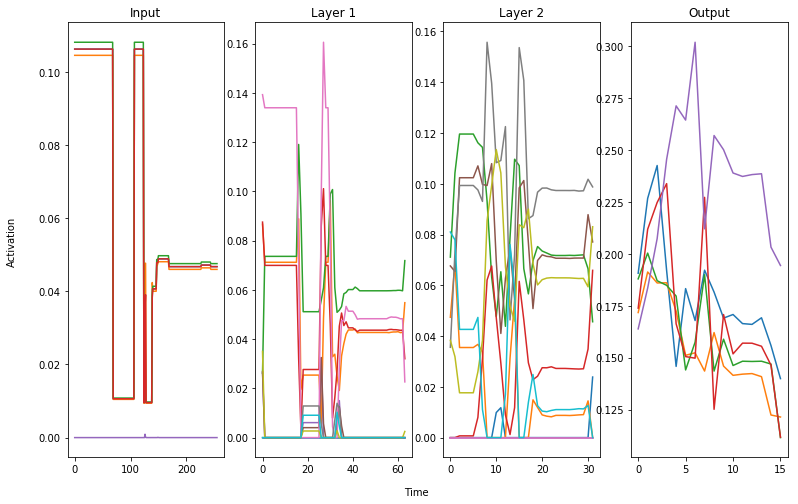

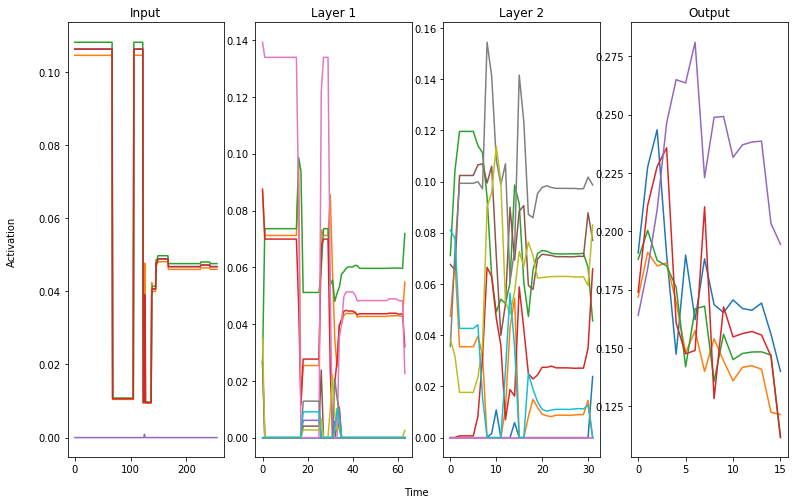

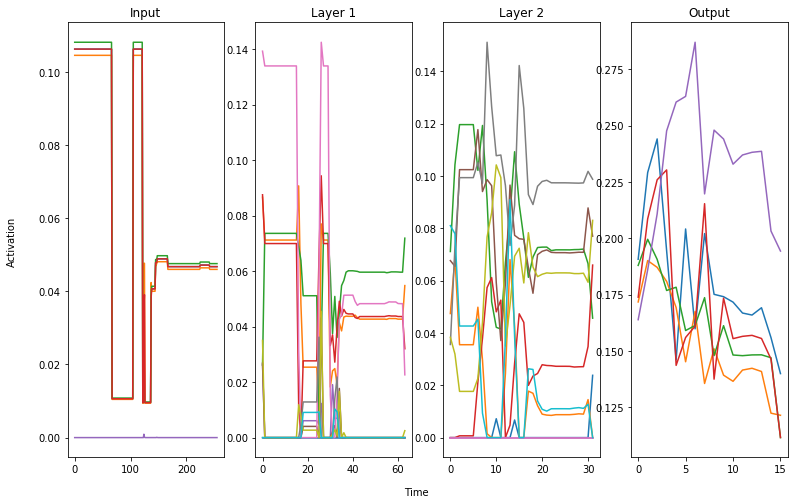

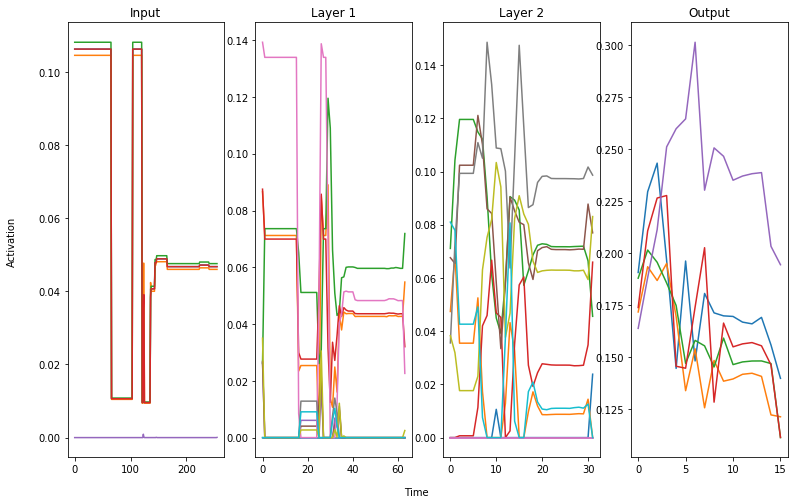

In [12]:
import matplotlib.pyplot as mpl
 
nt = 4
PF = cnnr.PredictFull(B[:nt])
for i in range(nt):
    fig, ax = mpl.subplots(1, 4, figsize = (16 / 1.24, 10 / 1.25))
    ax[0].plot(PF[0][i])
    ax[0].set_title('Input')
    ax[1].plot(PF[2][i])
    ax[1].set_title('Layer 1')
    ax[2].plot(PF[4][i])
    ax[2].set_title('Layer 2')
    ax[3].plot(PF[5][i])
    ax[3].set_title('Output')
    fig.text(0.5, 0.06, 'Time', ha='center')
    fig.text(0.06, 0.5, 'Activation', va='center', rotation='vertical')
    mpl.show()

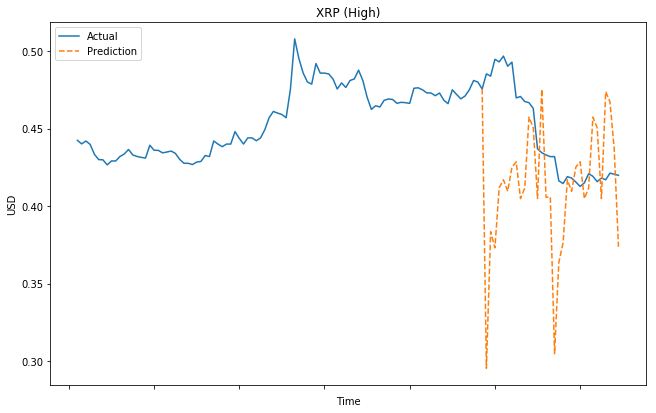

In [13]:
CI = list(range(C.shape[0]))
AI = list(range(C.shape[0] + PTS.shape[0] - HP))
NDP = PTS.shape[0] #Number of days predicted
for i, cli in enumerate(cl):
    fig, ax = mpl.subplots(figsize = (16 / 1.5, 10 / 1.5))
    hind = i * len(CN) + CN.index('high')
    ax.plot(CI[-4 * HP:], C[-4 * HP:, hind], label = 'Actual')
    ax.plot(AI[-(NDP + 1):], A[-(NDP + 1):, hind], '--', label = 'Prediction')
    ax.legend(loc = 'upper left')
    ax.set_title(cli + ' (High)')
    ax.set_ylabel('USD')
    ax.set_xlabel('Time')
    ax.axes.xaxis.set_ticklabels([])
    mpl.show()